In [ ]:
!pip install linearmodels stargazer
import pandas as pd
import numpy as np
import statsmodels.api as sm
import numpy.linalg as la
from scipy import stats
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import re
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from linearmodels.panel.results import compare # Para criar a tabela comparativa

In [2]:
# ---
# ETAPA 1: Carregamento e Preparação Inicial
# ---
print("--- Iniciando Etapa 1: Carregamento e Preparação ---")

# Caminho para o seu painel de dados final
caminho_painel = '/content/drive/MyDrive/02 - Economia (UFPE)/2025.1/Tópicos de Macro (Economia do clima)/analise-saneamento-chuva-extrema-pe/analysis/input/painel_final_pe.parquet'

try:
    df = pd.read_parquet(caminho_painel)
    print("Painel de dados final carregado com sucesso.")
except Exception as e:
    print(f"Erro ao carregar o arquivo: {e}")
    # exit() # Use exit() se estiver rodando como script .py


--- Iniciando Etapa 1: Carregamento e Preparação ---
Painel de dados final carregado com sucesso.


In [ ]:
# Preparar as variáveis para os modelos
# 1. Variável Dependente (Y): Escolha uma para o modelo principal
#    Exemplo: taxa de leptospirose
Y = df['taxa_lepto']

# 2. Variáveis Independentes (X)
#    Vamos usar a interpolação 'suave' (pchip) e a 'frequência' da chuva
#    para o modelo principal
X_vars = [
    'dias_chuva_extrema',
    'cobertura_esgoto_suave',
    'pib_per_capita_deflacionado',
    'densidade_populacional'
]

# Criar o termo de interação
df['interacao_chuva_esgoto'] = df['dias_chuva_extrema'] * df['cobertura_esgoto_suave']
X_vars.append('interacao_chuva_esgoto')

# Criar o DataFrame X e adicionar uma constante (intercepto)
X = sm.add_constant(df[X_vars])

print("Variáveis Y e X definidas para a análise.")

Variáveis Y e X definidas para a análise.



--- Iniciando Etapa 2: Testes de Colinearidade ---

Matriz de Correlação entre as variáveis independentes:
                             dias_chuva_extrema  cobertura_esgoto_suave  \
dias_chuva_extrema                     1.000000               -0.102717   
cobertura_esgoto_suave                -0.102717                1.000000   
pib_per_capita_deflacionado           -0.131776                0.221339   
densidade_populacional                 0.010033                0.130070   
interacao_chuva_esgoto                 0.524317                0.746218   

                             pib_per_capita_deflacionado  \
dias_chuva_extrema                             -0.131776   
cobertura_esgoto_suave                          0.221339   
pib_per_capita_deflacionado                     1.000000   
densidade_populacional                          0.145873   
interacao_chuva_esgoto                          0.075387   

                             densidade_populacional  interacao_chuva_esgoto  
di

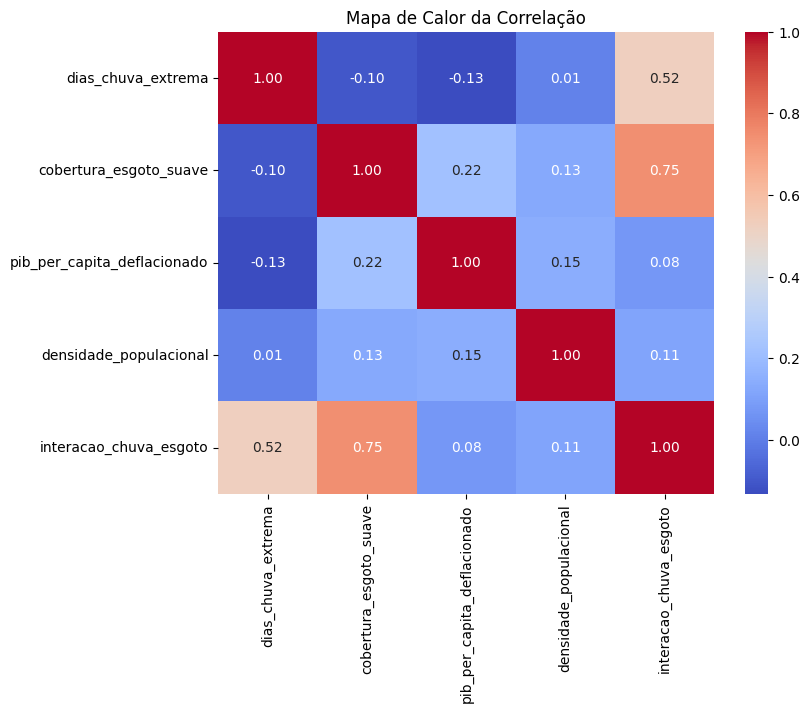

In [ ]:
# ---
# ETAPA 2: Testes Pré-Regressão (Análise de Colinearidade)
# ---
print("\n--- Iniciando Etapa 2: Testes de Colinearidade ---")

# 1. Matriz de Correlação
print("\nMatriz de Correlação entre as variáveis independentes:")
correlation_matrix = X[X_vars].corr()
print(correlation_matrix)

# Visualização da Matriz de Correlação
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Calor da Correlação")
# plt.show()

# 2. Fator de Inflação da Variância (VIF)
print("Calculando o Fator de Inflação da Variância (VIF):")
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)
print("Regra de bolso: VIF > 5 ou 10 pode indicar multicolinearidade problemática.")

In [ ]:
# Supondo que 'df' é seu painel de dados final
print("\nAplicando centralização na média para reduzir multicolinearidade...")

# 1. Calcular a média de cada variável
mean_chuva = df['dias_chuva_extrema'].mean()
mean_esgoto = df['cobertura_esgoto_suave'].mean()

# 2. Criar as variáveis centralizadas (subtraindo a média)
df['dias_chuva_extrema_c'] = df['dias_chuva_extrema'] - mean_chuva
df['cobertura_esgoto_suave_c'] = df['cobertura_esgoto_suave'] - mean_esgoto

# 3. Criar o NOVO termo de interação usando as variáveis centralizadas
df['interacao_chuva_esgoto_c'] = df['dias_chuva_extrema_c'] * df['cobertura_esgoto_suave_c']

# 4. Definir seu novo conjunto de variáveis X para os modelos
X_vars_centralizadas = [
    'dias_chuva_extrema_c',
    'cobertura_esgoto_suave_c',
    'interacao_chuva_esgoto_c', # O novo termo de interação
    'pib_per_capita_deflacionado',
    'densidade_populacional'
]

X_centralizado = sm.add_constant(df[X_vars_centralizadas])

# 5. Recalcular o VIF com as novas variáveis
print("\nCalculando o VIF com as variáveis centralizadas:")
vif_data_c = pd.DataFrame()
vif_data_c["feature"] = X_centralizado.columns
vif_data_c["VIF"] = [variance_inflation_factor(X_centralizado.values, i) for i in range(X_centralizado.shape[1])]
print(vif_data_c)


Aplicando centralização na média para reduzir multicolinearidade...

Calculando o VIF com as variáveis centralizadas:
                       feature       VIF
0                        const  2.193592
1         dias_chuva_extrema_c  1.029277
2     cobertura_esgoto_suave_c  1.069264
3     interacao_chuva_esgoto_c  1.013875
4  pib_per_capita_deflacionado  1.090313
5       densidade_populacional  1.034182


In [ ]:
# Preparar dados para linearmodels (com MultiIndex)
df_panel = df.set_index(['cod_municipio', 'ano'])

# Definir Y e X para o modelo
Y_panel = df_panel['taxa_lepto'] # Usando leptospirose como exemplo
X_panel_c = sm.add_constant(df_panel[X_vars_centralizadas])


# ---
# ESTIMAÇÃO DO MODELO
# ---
print("\n--- Iniciando Etapa 3: Estimação do Modelo Pooled OLS (com Variáveis Centralizadas) ---")

# Estimar o modelo
modelo_pooled_c = PooledOLS(Y_panel, X_panel_c).fit()
print(modelo_pooled_c)


--- Iniciando Etapa 3: Estimação do Modelo Pooled OLS (com Variáveis Centralizadas) ---
                          PooledOLS Estimation Summary                          
Dep. Variable:             taxa_lepto   R-squared:                        0.0951
Estimator:                  PooledOLS   R-squared (Between):              0.4058
No. Observations:                3700   R-squared (Within):              -0.0315
Date:                Tue, Aug 05 2025   R-squared (Overall):              0.0951
Time:                        00:21:27   Log-likelihood                   -8885.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      77.669
Entities:                         185   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                  F(5,3694)
Min Obs:                       20.000                                           
Max Obs:            

In [ ]:
# ---
# ETAPA 1: Transformar as variáveis Y e X
# ---
print("--- Aplicando transformação logarítmica em Y e no PIBpc ---")

# Usando o log-mais-um para a variável dependente para lidar com os zeros
df['ln_taxa_lepto'] = np.log(df['taxa_lepto'] + 1)

# Usando o log direto para o PIBpc (é improvável que seja zero ou negativo)
# Adicionamos um pequeno tratamento para o caso de haver algum valor não-positivo
df['ln_pib_pc_deflacionado'] = np.log(df['pib_per_capita_deflacionado'].clip(lower=1))

# ---
# ETAPA 2: Preparar os dados para o modelo
# ---
# Atualizar a lista de variáveis X para usar a nova variável de PIB em log
X_vars_log = [
    'dias_chuva_extrema_c',
    'cobertura_esgoto_suave_c',
    'interacao_chuva_esgoto_c',
    'ln_pib_pc_deflacionado', # <--- VARIÁVEL ATUALIZADA
    'densidade_populacional'
]

# Manter o MultiIndex
df_panel = df.set_index(['cod_municipio', 'ano'])

# Definir Y (em log) e X (com PIB em log)
Y_panel_log = df_panel['ln_taxa_lepto']
X_panel_log = sm.add_constant(df_panel[X_vars_log])

# ---
# ETAPA 3: Estimar o Modelo Pooled OLS (Log-Log)
# ---
print("\n--- Estimando o Modelo Pooled OLS (Log-Log para PIBpc) ---")

modelo_pooled_loglog = PooledOLS(Y_panel_log, X_panel_log).fit()
print(modelo_pooled_loglog)

--- Aplicando transformação logarítmica em Y e no PIBpc ---

--- Estimando o Modelo Pooled OLS (Log-Log para PIBpc) ---
                          PooledOLS Estimation Summary                          
Dep. Variable:          ln_taxa_lepto   R-squared:                        0.1777
Estimator:                  PooledOLS   R-squared (Between):              0.4604
No. Observations:                3700   R-squared (Within):              -0.0209
Date:                Tue, Aug 05 2025   R-squared (Overall):              0.1777
Time:                        00:21:36   Log-likelihood                   -3097.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      159.65
Entities:                         185   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                  F(5,3694)
Min Obs:                       20.000                                 

In [ ]:
# ---
# PREPARAÇÃO (Usando as variáveis em log)
# ---
# Supondo que 'df' é seu painel completo e já contém as colunas em log e centralizadas

# Definir as variáveis para o modelo Log-Log
Y_panel_log = df_panel['ln_taxa_lepto']
X_vars_log = [
    'dias_chuva_extrema_c',
    'cobertura_esgoto_suave_c',
    'interacao_chuva_esgoto_c',
    'ln_pib_pc_deflacionado',
    'densidade_populacional'
]
X_panel_log = sm.add_constant(df_panel[X_vars_log])

# ---
# TESTE DE HAUSMAN (Aplicado ao Modelo Log-Log)
# ---
print("\n--- Iniciando Teste de Hausman para a especificação Log-Log ---")

# 1. Estimar o modelo de Efeitos Aleatórios (EA) com as variáveis em log
modelo_ea_log = RandomEffects(Y_panel_log, X_panel_log).fit()
print("\n-- Modelo de Efeitos Aleatórios (Log-Log) --")
print(modelo_ea_log)

# 2. Estimar o modelo de Efeitos Fixos (EF) com as variáveis em log
modelo_ef_log = PanelOLS(Y_panel_log, X_panel_log, entity_effects=True).fit()
print("\n-- Modelo de Efeitos Fixos (Log-Log) para comparação --")
print(modelo_ef_log)


# 3. Reutilizar a função do teste de Hausman
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    common_params = list(re.params.index)
    b = b[common_params]
    df = b.shape[0]
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B))
    chi2 = np.dot(chi2, (b - B))
    p_value = stats.chi2.sf(chi2, df)
    return chi2, df, p_value

# 4. Executar e interpretar o teste com os novos modelos
try:
    chi2_stat, df, p_value = hausman(modelo_ef_log, modelo_ea_log)

    print("\nResultados do Teste de Hausman (para o modelo Log-Log):")
    print(f"  Estatística Chi-quadrado: {chi2_stat:.2f}")
    print(f"  Graus de liberdade: {df}")
    print(f"  P-valor: {p_value:.4f}")

    print("\n**Interpretação:**")
    if p_value < 0.05:
        print("  - O P-valor é menor que 0.05. Rejeitamos a hipótese nula.")
        print("  - **Conclusão:** O modelo de **Efeitos Fixos é a escolha correta e justificada** para a sua especificação final.")
    else:
        print("  - O P-valor é maior que 0.05. Não rejeitamos a hipótese nula.")
        print("  - Conclusão: O modelo de Efeitos Aleatórios seria o mais eficiente.")

except Exception as e:
    print(f"\nOcorreu um erro ao calcular o teste de Hausman: {e}")


--- Iniciando Teste de Hausman para a especificação Log-Log ---

-- Modelo de Efeitos Aleatórios (Log-Log) --
                        RandomEffects Estimation Summary                        
Dep. Variable:          ln_taxa_lepto   R-squared:                        0.0356
Estimator:              RandomEffects   R-squared (Between):              0.3702
No. Observations:                3700   R-squared (Within):               0.0033
Date:                Tue, Aug 05 2025   R-squared (Overall):              0.1547
Time:                        01:33:04   Log-likelihood                   -2579.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      27.290
Entities:                         185   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                  F(5,3694)
Min Obs:                       20.000                                          

In [ ]:
# Lidar com possíveis valores infinitos ou nulos antes de aplicar o log
# (Uma boa prática de defesa)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['taxa_lepto', 'taxa_arboviroses', 'pib_per_capita_deflacionado'], inplace=True)


# Criar as variáveis dependentes em log (usando log(y+1) para lidar com zeros)
df['ln_taxa_lepto'] = np.log(df['taxa_lepto'] + 1)
df['ln_taxa_arboviroses'] = np.log(df['taxa_arboviroses'] + 1)
df['ln_pib_pc_deflacionado'] = np.log(df['pib_per_capita_deflacionado'])


# Centralizar as variáveis principais na média para reduzir multicolinearidade
vars_to_center = [
    'dias_chuva_extrema', 'volume_total_chuva_extrema_mm',
    'cobertura_esgoto_suave', 'cobertura_agua_suave'
]
for var in vars_to_center:
    df[f'{var}_c'] = df[var] - df[var].mean()

# Criar a variável "elo mais fraco" e centralizá-la
df['saneamento_elo_fraco'] = df[['cobertura_agua_suave', 'cobertura_esgoto_suave']].min(axis=1)
df['saneamento_elo_fraco_c'] = df['saneamento_elo_fraco'] - df['saneamento_elo_fraco'].mean()

# Definir os controles base
controles_base = ['ln_pib_pc_deflacionado', 'densidade_populacional']

# Preparar o DataFrame para o linearmodels com MultiIndex
df_panel = df.set_index(['cod_municipio', 'ano'])


# ---
# ETAPA 2: Estimação Sequencial dos Modelos
# ---
print("\n--- Estimando os 9 modelos de Efeitos Fixos ---")

# Dicionário para armazenar os resultados
resultados = {}

# --- Modelo 1: Referência ---
print("Estimando Modelo 1: Referência...")
df_panel['interacao_1'] = df_panel['dias_chuva_extrema_c'] * df_panel['cobertura_esgoto_suave_c']
X1 = sm.add_constant(df_panel[['dias_chuva_extrema_c', 'cobertura_esgoto_suave_c', 'interacao_1'] + controles_base])
Y1 = df_panel['ln_taxa_lepto']
resultados['(1) Referência'] = PanelOLS(Y1, X1, entity_effects=True, time_effects=True).fit()

# --- Modelo 2: Medida do Choque (Intensidade) ---
print("Estimando Modelo 2: Choque por Intensidade...")
df_panel['interacao_2'] = df_panel['volume_total_chuva_extrema_mm_c'] * df_panel['cobertura_esgoto_suave_c']
X2 = sm.add_constant(df_panel[['volume_total_chuva_extrema_mm_c', 'cobertura_esgoto_suave_c', 'interacao_2'] + controles_base])
Y2 = df_panel['ln_taxa_lepto']
resultados['(2) Choque (Intens.)'] = PanelOLS(Y2, X2, entity_effects=True, time_effects=True).fit()

# --- Modelo 3: Mecanismo de Saneamento (Água) ---
print("Estimando Modelo 3: Saneamento por Água...")
df_panel['interacao_3'] = df_panel['dias_chuva_extrema_c'] * df_panel['cobertura_agua_suave_c']
X3 = sm.add_constant(df_panel[['dias_chuva_extrema_c', 'cobertura_agua_suave_c', 'interacao_3'] + controles_base])
Y3 = df_panel['ln_taxa_lepto']
resultados['(3) Saneam. (Água)'] = PanelOLS(Y3, X3, entity_effects=True, time_effects=True).fit()

# --- Modelo 4: Definição Agregada de Saneamento (Elo Fraco) ---
print("Estimando Modelo 4: Saneamento (Elo Fraco)...")
df_panel['interacao_4'] = df_panel['dias_chuva_extrema_c'] * df_panel['saneamento_elo_fraco_c']
X4 = sm.add_constant(df_panel[['dias_chuva_extrema_c', 'saneamento_elo_fraco_c', 'interacao_4'] + controles_base])
Y4 = df_panel['ln_taxa_lepto']
resultados['(4) Saneam. (Elo Fraco)'] = PanelOLS(Y4, X4, entity_effects=True, time_effects=True).fit()

# --- Modelo 5: Mecanismo da Doença (Arboviroses) ---
print("Estimando Modelo 5: Desfecho (Arboviroses)...")
df_panel['interacao_5'] = df_panel['dias_chuva_extrema_c'] * df_panel['cobertura_agua_suave_c'] # Usando água para arboviroses
X5 = sm.add_constant(df_panel[['dias_chuva_extrema_c', 'cobertura_agua_suave_c', 'interacao_5'] + controles_base])
Y5 = df_panel['ln_taxa_arboviroses']
resultados['(5) Desfecho (Arbov.)'] = PanelOLS(Y5, X5, entity_effects=True, time_effects=True).fit()

# --- Modelo 6: Impacto Econômico ---
print("Estimando Modelo 6: Desfecho (PIB pc)...")
df_panel['interacao_6'] = df_panel['dias_chuva_extrema_c'] * df_panel['cobertura_esgoto_suave_c']
# Retirar o PIB dos controles, pois agora é a variável dependente
controles_sem_pib = ['densidade_populacional']
X6 = sm.add_constant(df_panel[['dias_chuva_extrema_c', 'cobertura_esgoto_suave_c', 'interacao_6'] + controles_sem_pib])
Y6 = df_panel['ln_pib_pc_deflacionado']
resultados['(6) Desfecho (PIB)'] = PanelOLS(Y6, X6, entity_effects=True, time_effects=True).fit()

# --- Modelo 7: Dinâmica Temporal (Lag) ---
print("Estimando Modelo 7: Dinâmica Temporal...")
df_panel['ln_taxa_lepto_lag1'] = df_panel.groupby('cod_municipio')['ln_taxa_lepto'].shift(1)
df_panel['interacao_7'] = df_panel['dias_chuva_extrema_c'] * df_panel['cobertura_esgoto_suave_c']
controles_com_lag = controles_base + ['ln_taxa_lepto_lag1']
X7 = sm.add_constant(df_panel[['dias_chuva_extrema_c', 'cobertura_esgoto_suave_c', 'interacao_7'] + controles_com_lag])
Y7 = df_panel['ln_taxa_lepto']
resultados['(7) Dinâmica Temp.'] = PanelOLS(Y7, X7, entity_effects=True, time_effects=True).fit()

# Primeiro, criar as variáveis dependentes em log para as novas doenças
df['ln_taxa_esquisto'] = np.log(df['taxa_esquisto'] + 1)
df['ln_taxa_febretifoide'] = np.log(df['taxa_febretifoide'] + 1)

# Atualizar o DataFrame do painel
df_panel = df.set_index(['cod_municipio', 'ano'])

# --- Modelo 8: Desfecho (Esquistossomose) ---
print("Estimando Modelo 8: Desfecho (Esquistossomose)...")
# Para esquistossomose, o mecanismo principal é o esgoto
df_panel['interacao_8'] = df_panel['dias_chuva_extrema_c'] * df_panel['cobertura_esgoto_suave_c']
X8 = sm.add_constant(df_panel[['dias_chuva_extrema_c', 'cobertura_esgoto_suave_c', 'interacao_8'] + controles_base])
Y8 = df_panel['ln_taxa_esquisto']
resultados['(8) Desfecho (Esquisto.)'] = PanelOLS(Y8, X8, entity_effects=True, time_effects=True).fit()

# --- Modelo 9: Desfecho (Febre Tifoide) ---
print("Estimando Modelo 9: Desfecho (Febre Tifoide)...")
# Para febre tifoide, o mecanismo principal é a água potável
df_panel['interacao_9'] = df_panel['dias_chuva_extrema_c'] * df_panel['cobertura_agua_suave_c']
X9 = sm.add_constant(df_panel[['dias_chuva_extrema_c', 'cobertura_agua_suave_c', 'interacao_9'] + controles_base])
Y9 = df_panel['ln_taxa_febretifoide']
resultados['(9) Desfecho (Febre Tif.)'] = PanelOLS(Y9, X9, entity_effects=True, time_effects=True).fit()

# ---
# ETAPA 3: Apresentar os Resultados em uma Tabela Comparativa (Versão Final)
# ---
print("\n--- Gerando Tabela de Resultados Formatada com Stargazer ---")

# 1. Instanciar o Stargazer com a lista dos seus modelos
# Pegamos os 'values' do dicionário para ter a lista de modelos
stargazer = Stargazer(list(resultados.values()))

# 2. Customizar a Tabela (Opcional, mas recomendado)

# Mudar os nomes das colunas (títulos dos modelos)
stargazer.custom_columns(list(resultados.keys()), [1, 1, 1, 1, 1, 1, 1, 1, 1])

# Renomear as variáveis para nomes mais curtos e legíveis
stargazer.rename_covariates({
    'const': 'Constante',
    'dias_chuva_extrema_c': 'Dias Chuva Extrema',
    'volume_total_chuva_extrema_mm_c': 'Volume Chuva Extrema',
    'cobertura_esgoto_suave_c': 'Cob. Esgoto',
    'cobertura_agua_suave_c': 'Cob. Água',
    'saneamento_elo_fraco_c': 'Saneam. (Elo Fraco)',
    'ln_pib_pc_deflacionado': 'ln(PIB pc)',
    'densidade_populacional': 'Densidade Pop.',
    'ln_taxa_lepto_lag1': 'ln(Taxa Lepto) [t-1]',
    'interacao_1': 'Chuva * Esgoto',
    'interacao_2': 'Volume * Esgoto',
    'interacao_3': 'Chuva * Água',
    'interacao_4': 'Chuva * Elo Fraco',
    'interacao_5': 'Chuva * Água (Arbov.)',
    'interacao_6': 'Chuva * Esgoto (PIB)',
    'interacao_7': 'Chuva * Esgoto (Lag)',
    'interacao_8': 'Chuva * Esgoto (Esquisto.)',
    'interacao_9': 'Chuva * Água (Febre Tif.)'
})

# Definir quais linhas de estatísticas mostrar no final da tabela
stargazer.show_degrees_of_freedom = False
stargazer.show_f_statistic = False
stargazer.show_r2 = True
stargazer.show_adj_r2 = False
stargazer.show_nobs = True


# Adicionar notas customizadas
stargazer.add_custom_notes([
    'Efeitos fixos de município e ano incluídos em todos os modelos.',
    'Erros padrão entre parênteses. *** p<0.01, ** p<0.05, * p<0.1'
])

# 3. Exibir a Tabela em formato HTML (ótimo para notebooks)
HTML(stargazer.render_html())
# 4. (Opcional) Salvar a tabela em formato LaTeX para seu artigo
latex_code = stargazer.render_latex()
with open('/content/drive/MyDrive/02 - Economia (UFPE)/2025.1/Tópicos de Macro (Economia do clima)/analise-saneamento-chuva-extrema-pe/analysis/output/tabelas/tabela_resultados_finais.tex', 'w') as f:
    f.write(latex_code)
print("\nTabela salva em formato LaTeX.")

In [ ]:
HTML(stargazer.render_html())

In [ ]:
# Lidar com nulos e infinitos e criar variáveis em log
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True) # Remover todas as linhas com nulos para garantir consistência
df['ln_taxa_lepto'] = np.log(df['taxa_lepto'] + 1)
df['ln_pib_pc_deflacionado'] = np.log(df['pib_per_capita_deflacionado'])

# Centralizar variáveis na média
vars_to_center = ['dias_chuva_extrema', 'cobertura_esgoto_suave']
for var in vars_to_center:
    df[f'{var}_c'] = df[var] - df[var].mean()

# Criar o termo de interação
df['interacao_chuva_esgoto_c'] = df['dias_chuva_extrema_c'] * df['cobertura_esgoto_suave_c']

# Preparar o DataFrame para o linearmodels com MultiIndex
df_panel = df.set_index(['cod_municipio', 'ano'])

# ---
# ETAPA 2: Estimar os dois modelos
# ---
print("--- Estimando os modelos com e sem controles ---")

# Dicionário para armazenar os resultados
resultados_controle = {}

# Definir a variável dependente
Y = df_panel['ln_taxa_lepto']

# --- Modelo 1: Sem Controles de PIB e Densidade ---
vars_sem_controles = ['dias_chuva_extrema_c', 'cobertura_esgoto_suave_c', 'interacao_chuva_esgoto_c']
X_sem_controles = sm.add_constant(df_panel[vars_sem_controles])
resultados_controle['(1) Sem Controles'] = PanelOLS(Y, X_sem_controles, entity_effects=True, time_effects=True).fit()

# --- Modelo 2: Com Controles de PIB e Densidade (Seu Modelo de Referência) ---
vars_com_controles = vars_sem_controles + ['ln_pib_pc_deflacionado', 'densidade_populacional']
X_com_controles = sm.add_constant(df_panel[vars_com_controles])
resultados_controle['(2) Com Controles'] = PanelOLS(Y, X_com_controles, entity_effects=True, time_effects=True).fit()


# ---
# ETAPA 3: Comparar os Resultados
# ---
print("\n--- Tabela Comparativa: Efeito da Inclusão dos Controles ---")
tabela_comparativa_controles = compare(resultados_controle, stars=True, precision='std_errors')
print(tabela_comparativa_controles)

--- Estimando os modelos com e sem controles ---

--- Tabela Comparativa: Efeito da Inclusão dos Controles ---
                            Model Comparison                           
                                    (1) Sem Controles (2) Com Controles
-----------------------------------------------------------------------
Dep. Variable                           ln_taxa_lepto     ln_taxa_lepto
Estimator                                    PanelOLS          PanelOLS
No. Observations                                 3700              3700
Cov. Est.                                  Unadjusted        Unadjusted
R-squared                                      0.0017            0.0069
R-Squared (Within)                            -0.0057            0.0098
R-Squared (Between)                            0.0249           -6.7641
R-Squared (Overall)                            0.0069           -2.7851
F-statistic                                    2.0074            4.8471
P-value (F-stat)         

In [ ]:
# Lidar com nulos e criar as variáveis necessárias (log, centralizadas, interação)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df['ln_taxa_lepto'] = np.log(df['taxa_lepto'] + 1)
df['ln_pib_pc_deflacionado'] = np.log(df['pib_per_capita_deflacionado'])
vars_to_center = ['dias_chuva_extrema', 'cobertura_esgoto_suave', 'cobertura_agua_suave']
for var in vars_to_center:
    df[f'{var}_c'] = df[var] - df[var].mean()
df['interacao_chuva_esgoto_c'] = df['dias_chuva_extrema_c'] * df['cobertura_esgoto_suave_c']


# 1. Usar um único ano de referência (ex: 2021) para a classificação
ano_referencia = 2021
df_referencia = df[df['ano'] == ano_referencia]

# 2. Calcular a mediana da densidade populacional nesse ano de referência
mediana_densidade = df_referencia['densidade_populacional'].median()
print(f"Mediana da densidade populacional em {ano_referencia} usada como critério: {mediana_densidade:.2f} hab/km²")

# 3. OBTER a lista de códigos dos municípios de cada grupo, baseado SOMENTE nos dados de referência
municipios_alta_densidade = df_referencia[df_referencia['densidade_populacional'] >= mediana_densidade]['cod_municipio'].unique()
municipios_baixa_densidade = df_referencia[df_referencia['densidade_populacional'] < mediana_densidade]['cod_municipio'].unique()

# 4. CRIAR os DataFrames das subamostras usando a lista de códigos para filtrar o painel COMPLETO
df_alta_densidade = df[df['cod_municipio'].isin(municipios_alta_densidade)]
df_baixa_densidade = df[df['cod_municipio'].isin(municipios_baixa_densidade)]


# ---
# Verificação Final
# ---
print(f"\nNúmero de municípios no grupo 'Alta Densidade': {len(municipios_alta_densidade)}")
print(f"Número de municípios no grupo 'Baixa Densidade': {len(municipios_baixa_densidade)}")
print(f"Total de municípios classificados: {len(municipios_alta_densidade) + len(municipios_baixa_densidade)}")

# ---
# ETAPA 3: Estimar o Modelo de Efeitos Fixos para Cada Subamostra (Nomes Corrigidos)
# ---
print("\n--- Estimando os modelos para cada subamostra de densidade populacional ---")

# Dicionário para armazenar os resultados
resultados_subamostras = {}

# Definir as variáveis do modelo (as mesmas do seu modelo de referência)
Y_var = 'ln_taxa_lepto'
X_vars = [
    'dias_chuva_extrema_c',
    'cobertura_esgoto_suave_c',
    'interacao_chuva_esgoto_c',
    'ln_pib_pc_deflacionado',
    'densidade_populacional'
]

# -- Modelo para o grupo de ALTA DENSIDADE --
# Usando o DataFrame correto: df_alta_densidade
df_panel_alta = df_alta_densidade.set_index(['cod_municipio', 'ano'])
Y_alta = df_panel_alta[Y_var]
X_alta = sm.add_constant(df_panel_alta[X_vars])
# Atualizando o nome no dicionário de resultados
resultados_subamostras['(1) Alta Densidade'] = PanelOLS(Y_alta, X_alta, entity_effects=True, time_effects=True).fit()

# -- Modelo para o grupo de BAIXA DENSIDADE --
# Usando o DataFrame correto: df_baixa_densidade
df_panel_baixa = df_baixa_densidade.set_index(['cod_municipio', 'ano'])
Y_baixa = df_panel_baixa[Y_var]
X_baixa = sm.add_constant(df_panel_baixa[X_vars])
# Atualizando o nome no dicionário de resultados
resultados_subamostras['(2) Baixa Densidade'] = PanelOLS(Y_baixa, X_baixa, entity_effects=True, time_effects=True).fit()


# ---
# ETAPA 4: Comparar os Resultados
# ---
print("\n--- Tabela Comparativa dos Resultados por Subamostra de Densidade ---")
tabela_comparativa_subamostras = compare(resultados_subamostras, stars=True, precision='std_errors')
print(tabela_comparativa_subamostras)

Mediana da densidade populacional em 2021 usada como critério: 96.07 hab/km²

Número de municípios no grupo 'Alta Densidade': 93
Número de municípios no grupo 'Baixa Densidade': 92
Total de municípios classificados: 185

--- Estimando os modelos para cada subamostra de densidade populacional ---

--- Tabela Comparativa dos Resultados por Subamostra de Densidade ---
                          Model Comparison                         
                             (1) Alta Densidade (2) Baixa Densidade
-------------------------------------------------------------------
Dep. Variable                     ln_taxa_lepto       ln_taxa_lepto
Estimator                              PanelOLS            PanelOLS
No. Observations                           1860                1840
Cov. Est.                            Unadjusted          Unadjusted
R-squared                                0.0063              0.0013
R-Squared (Within)                       0.0073             -0.0079
R-Squared (Between) 

In [ ]:
# ---
# ETAPA 1: Preparar as novas variáveis dependentes (log + 1)
# ---
print("--- Preparando as novas variáveis dependentes ---")
df['ln_taxa_esquisto'] = np.log(df['taxa_esquisto'] + 1)
df['ln_taxa_arboviroses'] = np.log(df['taxa_arboviroses'] + 1)

# Atualizar os dataframes das subamostras para incluir as novas colunas
df_alta_densidade = df[df['cod_municipio'].isin(municipios_alta_densidade)]
df_baixa_densidade = df[df['cod_municipio'].isin(municipios_baixa_densidade)]


# ---
# ETAPA 2: Teste de Heterogeneidade para ESQUISTOSSOMOSE
# ---
print("\n--- Estimando modelos para Esquistossomose por subamostra ---")

# Para Esquistossomose, o mecanismo principal é o ESGOTO
Y_var_esquisto = 'ln_taxa_esquisto'
X_vars_esgoto = [
    'dias_chuva_extrema_c',
    'cobertura_esgoto_suave_c',
    'interacao_chuva_esgoto_c', # Interação com esgoto
    'ln_pib_pc_deflacionado',
    'densidade_populacional'
]

# Estimar os modelos para cada subgrupo
resultados_esquisto = {}
# Alta Densidade
df_panel_alta = df_alta_densidade.set_index(['cod_municipio', 'ano'])
Y_alta = df_panel_alta[Y_var_esquisto]
X_alta = sm.add_constant(df_panel_alta[X_vars_esgoto])
resultados_esquisto['(1) Alta Densidade'] = PanelOLS(Y_alta, X_alta, entity_effects=True, time_effects=True).fit()
# Baixa Densidade
df_panel_baixa = df_baixa_densidade.set_index(['cod_municipio', 'ano'])
Y_baixa = df_panel_baixa[Y_var_esquisto]
X_baixa = sm.add_constant(df_panel_baixa[X_vars_esgoto])
resultados_esquisto['(2) Baixa Densidade'] = PanelOLS(Y_baixa, X_baixa, entity_effects=True, time_effects=True).fit()

# Comparar os resultados
print("\n--- Tabela Comparativa para Esquistossomose ---")
tabela_esquisto = compare(resultados_esquisto, stars=True, precision='std_errors')
print(tabela_esquisto)

--- Preparando as novas variáveis dependentes ---

--- Estimando modelos para Esquistossomose por subamostra ---

--- Tabela Comparativa para Esquistossomose ---
                           Model Comparison                           
                               (1) Alta Densidade  (2) Baixa Densidade
----------------------------------------------------------------------
Dep. Variable                    ln_taxa_esquisto     ln_taxa_esquisto
Estimator                                PanelOLS             PanelOLS
No. Observations                             1860                 1840
Cov. Est.                              Unadjusted           Unadjusted
R-squared                                  0.0318               0.0108
R-Squared (Within)                        -0.2334               0.0001
R-Squared (Between)                       -21.275               0.0175
R-Squared (Overall)                       -4.4145               0.0066
F-statistic                                11.446        

In [ ]:
# ---
# ETAPA 3: Teste de Heterogeneidade para ARBOVIROSES
# ---
print("\n\n--- Estimando modelos para Arboviroses por subamostra ---")

# Para Arboviroses, o mecanismo principal é o ARMAZENAMENTO DE ÁGUA
Y_var_arbov = 'ln_taxa_arboviroses'
# Criar o termo de interação específico para ÁGUA
df['interacao_chuva_agua_c'] = df['dias_chuva_extrema_c'] * df['cobertura_agua_suave_c']
X_vars_agua = [
    'dias_chuva_extrema_c',
    'cobertura_agua_suave_c',
    'interacao_chuva_agua_c', # Interação com água
    'ln_pib_pc_deflacionado',
    'densidade_populacional'
]

# Atualizar os dataframes das subamostras com a nova interação
df_alta_densidade = df[df['cod_municipio'].isin(municipios_alta_densidade)]
df_baixa_densidade = df[df['cod_municipio'].isin(municipios_baixa_densidade)]

# Estimar os modelos para cada subgrupo
resultados_arbov = {}
# Alta Densidade
df_panel_alta = df_alta_densidade.set_index(['cod_municipio', 'ano'])
Y_alta = df_panel_alta[Y_var_arbov]
X_alta = sm.add_constant(df_panel_alta[X_vars_agua])
resultados_arbov['(1) Alta Densidade'] = PanelOLS(Y_alta, X_alta, entity_effects=True, time_effects=True).fit()
# Baixa Densidade
df_panel_baixa = df_baixa_densidade.set_index(['cod_municipio', 'ano'])
Y_baixa = df_panel_baixa[Y_var_arbov]
X_baixa = sm.add_constant(df_panel_baixa[X_vars_agua])
resultados_arbov['(2) Baixa Densidade'] = PanelOLS(Y_baixa, X_baixa, entity_effects=True, time_effects=True).fit()

# Comparar os resultados
print("\n--- Tabela Comparativa para Arboviroses ---")
tabela_arbov = compare(resultados_arbov, stars=True, precision='std_errors')
print(tabela_arbov)



--- Estimando modelos para Arboviroses por subamostra ---

--- Tabela Comparativa para Arboviroses ---
                             Model Comparison                             
                                (1) Alta Densidade     (2) Baixa Densidade
--------------------------------------------------------------------------
Dep. Variable                  ln_taxa_arboviroses     ln_taxa_arboviroses
Estimator                                 PanelOLS                PanelOLS
No. Observations                              1860                    1840
Cov. Est.                               Unadjusted              Unadjusted
R-squared                                   0.0024                  0.0058
R-Squared (Within)                          0.0137                  0.0282
R-Squared (Between)                        -0.8823                 -0.0301
R-Squared (Overall)                        -0.1130                  0.0214
F-statistic                                 0.8219                  1.

In [ ]:
# Lidar com nulos e criar as variáveis necessárias (log, centralizadas, interação)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df['ln_taxa_lepto'] = np.log(df['taxa_lepto'] + 1)
df['ln_pib_pc_deflacionado'] = np.log(df['pib_per_capita_deflacionado'])
vars_to_center = ['dias_chuva_extrema', 'cobertura_esgoto_suave']
for var in vars_to_center:
    df[f'{var}_c'] = df[var] - df[var].mean()
df['interacao_chuva_esgoto_c'] = df['dias_chuva_extrema_c'] * df['cobertura_esgoto_suave_c']

# ---
# ETAPA 2: Definir os Subperíodos e Criar as Amostras
# ---
print("\n--- Definindo os subperíodos para a análise ---")

# Período 1: Primeiros 7 anos
df_periodo1 = df[df['ano'].between(2002, 2008)]
# Período 2: 7 anos do meio
df_periodo2 = df[df['ano'].between(2009, 2015)]
# Período 3: 6 anos finais
df_periodo3 = df[df['ano'].between(2016, 2021)]

print(f"Período 1 (2002-2008) tem {len(df_periodo1)} observações.")
print(f"Período 2 (2009-2015) tem {len(df_periodo2)} observações.")
print(f"Período 3 (2016-2021) tem {len(df_periodo3)} observações.")

# ---
# ETAPA 3: Estimar o Modelo de Efeitos Fixos para Cada Subperíodo
# ---
print("\n--- Estimando os modelos para cada subperíodo ---")

# Dicionário para armazenar os resultados
resultados_periodos = {}

# Definir as variáveis do modelo (as mesmas do seu modelo de referência)
Y_var = 'ln_taxa_lepto'
X_vars = [
    'dias_chuva_extrema_c',
    'cobertura_esgoto_suave_c',
    'interacao_chuva_esgoto_c',
    'ln_pib_pc_deflacionado',
    'densidade_populacional'
]

# -- Modelo para o Período 1 --
df_panel1 = df_periodo1.set_index(['cod_municipio', 'ano'])
Y1 = df_panel1[Y_var]
X1 = sm.add_constant(df_panel1[X_vars])
resultados_periodos['(1) 2002-2008'] = PanelOLS(Y1, X1, entity_effects=True, time_effects=True).fit()

# -- Modelo para o Período 2 --
df_panel2 = df_periodo2.set_index(['cod_municipio', 'ano'])
Y2 = df_panel2[Y_var]
X2 = sm.add_constant(df_panel2[X_vars])
resultados_periodos['(2) 2009-2015'] = PanelOLS(Y2, X2, entity_effects=True, time_effects=True).fit()

# -- Modelo para o Período 3 --
df_panel3 = df_periodo3.set_index(['cod_municipio', 'ano'])
Y3 = df_panel3[Y_var]
X3 = sm.add_constant(df_panel3[X_vars])
resultados_periodos['(3) 2016-2021'] = PanelOLS(Y3, X3, entity_effects=True, time_effects=True).fit()

# ---
# ETAPA 4: Comparar os Resultados
# ---
print("\n--- Tabela Comparativa dos Resultados por Subperíodo ---")
tabela_comparativa_periodos = compare(resultados_periodos, stars=True, precision='std_errors')
print(tabela_comparativa_periodos)


--- Definindo os subperíodos para a análise ---
Período 1 (2002-2008) tem 1295 observações.
Período 2 (2009-2015) tem 1295 observações.
Período 3 (2016-2021) tem 1110 observações.

--- Estimando os modelos para cada subperíodo ---

--- Tabela Comparativa dos Resultados por Subperíodo ---
                                 Model Comparison                                 
                                 (1) 2002-2008     (2) 2009-2015     (3) 2016-2021
----------------------------------------------------------------------------------
Dep. Variable                    ln_taxa_lepto     ln_taxa_lepto     ln_taxa_lepto
Estimator                             PanelOLS          PanelOLS          PanelOLS
No. Observations                          1295              1295              1110
Cov. Est.                           Unadjusted        Unadjusted        Unadjusted
R-squared                               0.0119            0.0079            0.0100
R-Squared (Within)                     -0.0011

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
health_vars = ['taxa_lepto', 'taxa_arboviroses', 'taxa_esquisto', 'taxa_febretifoide']
for var in health_vars:
    df[f'ln_{var}'] = np.log(df[var] + 1)
df['ln_pib_pc_deflacionado'] = np.log(df['pib_per_capita_deflacionado'])

vars_to_center = ['dias_chuva_extrema', 'volume_total_chuva_extrema_mm',
                  'cobertura_esgoto_suave', 'cobertura_agua_suave']
for var in vars_to_center:
    df[f'{var}_c'] = df[var] - df[var].mean()

df['saneamento_elo_fraco'] = df[['cobertura_agua_suave', 'cobertura_esgoto_suave']].min(axis=1)
df['saneamento_elo_fraco_c'] = df['saneamento_elo_fraco'] - df['saneamento_elo_fraco'].mean()

# --- CRIAÇÃO DE TODAS AS INTERAÇÕES NO DATAFRAME PRINCIPAL ---
df['interacao_chuva_esgoto_c'] = df['dias_chuva_extrema_c'] * df['cobertura_esgoto_suave_c']
df['interacao_volume_esgoto_c'] = df['volume_total_chuva_extrema_mm_c'] * df['cobertura_esgoto_suave_c']
df['interacao_chuva_agua_c'] = df['dias_chuva_extrema_c'] * df['cobertura_agua_suave_c']
df['interacao_chuva_elo_fraco_c'] = df['dias_chuva_extrema_c'] * df['saneamento_elo_fraco_c']
df['ln_taxa_lepto_lag1'] = df.groupby('cod_municipio')['ln_taxa_lepto'].shift(1)
df.dropna(inplace=True) # Remover nulos criados pelo lag

# Definir controles base
controles_base = ['ln_pib_pc_deflacionado', 'densidade_populacional']

# ---
# ETAPA 2: Geração das Tabelas
# ---

# ==============================================================================
# Tabela 1: Modelo Base para Leptospirose e Testes de Robustez da Especificação
# ==============================================================================
print("\n--- Gerando Tabela 1: Modelo Base e Robustez (Leptospirose) ---")
resultados_t1 = {}
df_panel = df.set_index(['cod_municipio', 'ano'])
dep_var_t1 = 'ln_taxa_lepto'

X1_vars = ['dias_chuva_extrema_c', 'cobertura_esgoto_suave_c', 'interacao_chuva_esgoto_c'] + controles_base
resultados_t1['(1) Base'] = PanelOLS(df_panel[dep_var_t1], sm.add_constant(df_panel[X1_vars]), entity_effects=True, time_effects=True).fit()

X2_vars = ['volume_total_chuva_extrema_mm_c', 'cobertura_esgoto_suave_c', 'interacao_volume_esgoto_c'] + controles_base
resultados_t1['(2) Choque (Volume)'] = PanelOLS(df_panel[dep_var_t1], sm.add_constant(df_panel[X2_vars]), entity_effects=True, time_effects=True).fit()

X3_vars = ['dias_chuva_extrema_c', 'cobertura_agua_suave_c', 'interacao_chuva_agua_c'] + controles_base
resultados_t1['(3) Saneam. (Água)'] = PanelOLS(df_panel[dep_var_t1], sm.add_constant(df_panel[X3_vars]), entity_effects=True, time_effects=True).fit()

X4_vars = ['dias_chuva_extrema_c', 'saneamento_elo_fraco_c', 'interacao_chuva_elo_fraco_c'] + controles_base
resultados_t1['(4) Saneam. (Elo Fraco)'] = PanelOLS(df_panel[dep_var_t1], sm.add_constant(df_panel[X4_vars]), entity_effects=True, time_effects=True).fit()

tabela1 = Stargazer(list(resultados_t1.values()))
tabela1.custom_columns(list(resultados_t1.keys()), [1, 1, 1, 1])
tabela1.title('Tabela 1: Modelo Base para Leptospirose e Testes de Robustez da Especificação')
display(HTML(tabela1.render_html()))

# ==============================================================================
# Tabela 2: Testes com Variáveis Dependentes Alternativas
# ==============================================================================
print("\n--- Gerando Tabela 2: Desfechos de Saúde Alternativos ---")
resultados_t2 = {}
resultados_t2['(1) Arboviroses'] = PanelOLS(df_panel['ln_taxa_arboviroses'], sm.add_constant(df_panel[X3_vars]), entity_effects=True, time_effects=True).fit()
resultados_t2['(2) Esquistossomose'] = PanelOLS(df_panel['ln_taxa_esquisto'], sm.add_constant(df_panel[X1_vars]), entity_effects=True, time_effects=True).fit()
resultados_t2['(3) Febre Tifoide'] = PanelOLS(df_panel['ln_taxa_febretifoide'], sm.add_constant(df_panel[X3_vars]), entity_effects=True, time_effects=True).fit()

tabela2 = Stargazer(list(resultados_t2.values()))
tabela2.custom_columns(['Arboviroses', 'Esquistossomose', 'Febre Tifoide'], [1, 1, 1])
tabela2.title('Tabela 2: Análise para Desfechos de Saúde Alternativos')
display(HTML(tabela2.render_html()))

# ==============================================================================
# Tabela 3: Análise de Heterogeneidade por Densidade Populacional
# ==============================================================================
print("\n--- Gerando Tabela 3: Análise de Subamostras por Densidade ---")
resultados_t3 = {}
ano_referencia = 2021
df_referencia = df[df['ano'] == ano_referencia]
mediana_densidade = df_referencia['densidade_populacional'].median()
municipios_alta = df_referencia[df_referencia['densidade_populacional'] >= mediana_densidade]['cod_municipio'].unique()
df_alta_densidade = df[df['cod_municipio'].isin(municipios_alta)]
df_baixa_densidade = df[~df['cod_municipio'].isin(municipios_alta)]

df_panel_alta = df_alta_densidade.set_index(['cod_municipio', 'ano'])
resultados_t3['(1) Alta Densidade'] = PanelOLS(df_panel_alta['ln_taxa_lepto'], sm.add_constant(df_panel_alta[X1_vars]), entity_effects=True, time_effects=True).fit()

df_panel_baixa = df_baixa_densidade.set_index(['cod_municipio', 'ano'])
resultados_t3['(2) Baixa Densidade'] = PanelOLS(df_panel_baixa['ln_taxa_lepto'], sm.add_constant(df_panel_baixa[X1_vars]), entity_effects=True, time_effects=True).fit()

tabela3 = Stargazer(list(resultados_t3.values()))
tabela3.custom_columns(list(resultados_t3.keys()), [1, 1])
tabela3.title('Tabela 3: Análise de Heterogeneidade por Densidade (Desfecho: Leptospirose)')
display(HTML(tabela3.render_html()))

# ==============================================================================
# Tabela 4: Análise de Estabilidade Temporal (Subperíodos)
# ==============================================================================
print("\n--- Gerando Tabela 4: Análise em Subperíodos ---")
resultados_t4 = {}
df_p1 = df[df['ano'].between(2002, 2008)]
df_p2 = df[df['ano'].between(2009, 2015)]
df_p3 = df[df['ano'].between(2016, 2021)]

df_panel_p1 = df_p1.set_index(['cod_municipio', 'ano'])
resultados_t4['(1) 2002-2008'] = PanelOLS(df_panel_p1['ln_taxa_lepto'], sm.add_constant(df_panel_p1[X1_vars]), entity_effects=True, time_effects=True).fit()

df_panel_p2 = df_p2.set_index(['cod_municipio', 'ano'])
resultados_t4['(2) 2009-2015'] = PanelOLS(df_panel_p2['ln_taxa_lepto'], sm.add_constant(df_panel_p2[X1_vars]), entity_effects=True, time_effects=True).fit()

df_panel_p3 = df_p3.set_index(['cod_municipio', 'ano'])
resultados_t4['(3) 2016-2021'] = PanelOLS(df_panel_p3['ln_taxa_lepto'], sm.add_constant(df_panel_p3[X1_vars]), entity_effects=True, time_effects=True).fit()

tabela4 = Stargazer(list(resultados_t4.values()))
tabela4.custom_columns(list(resultados_t4.keys()), [1, 1, 1])
tabela4.title('Tabela 4: Análise de Estabilidade Temporal (Desfecho: Leptospirose)')
display(HTML(tabela4.render_html()))


--- Gerando Tabela 1: Modelo Base e Robustez (Leptospirose) ---



--- Gerando Tabela 2: Desfechos de Saúde Alternativos ---



--- Gerando Tabela 3: Análise de Subamostras por Densidade ---



--- Gerando Tabela 4: Análise em Subperíodos ---


In [ ]:
# Supondo que 'resultados_t1' é o seu dicionário com os resultados da Tabela 1

# Pegar o resultado do seu modelo de referência (Modelo 1 da Tabela 1)
modelo_referencia = resultados_t1['(1) Base']

# Acessar e imprimir os coeficientes com precisão total
coeficientes_precisos = modelo_referencia.params

print("--- Coeficientes com Precisão Total (Modelo de Referência) ---")
print(coeficientes_precisos)

# Exemplo de como pegar um coeficiente específico
beta_interacao = coeficientes_precisos['interacao_chuva_esgoto_c']
print(f"\nValor exato do coeficiente de interação: {beta_interacao}")

--- Coeficientes com Precisão Total (Modelo de Referência) ---
const                       1.225692
dias_chuva_extrema_c        0.000370
cobertura_esgoto_suave_c    0.001418
interacao_chuva_esgoto_c    0.000023
ln_pib_pc_deflacionado     -0.086675
densidade_populacional     -0.000724
Name: parameter, dtype: float64

Valor exato do coeficiente de interação: 2.295544605550535e-05


In [ ]:
# Coeficientes exatos do seu modelo de Efeitos Fixos
beta_chuva = coeficientes_precisos['dias_chuva_extrema_c']
beta_esgoto = coeficientes_precisos['cobertura_esgoto_suave_c']
beta_pib = coeficientes_precisos['ln_pib_pc_deflacionado']
beta_densidade = coeficientes_precisos['densidade_populacional']

# Cálculo do efeito percentual
efeito_chuva_pct = (np.exp(beta_chuva) - 1) * 100
print(f"Efeito percentual da chuva: {efeito_chuva_pct:.4f}%")

Efeito percentual da chuva: 0.0370%


In [ ]:
# Efeito da chuva em um município com saneamento 20 pp ABAIXO da média
esgoto_baixo = -20
efeito_chuva_esgoto_baixo = (np.exp(beta_chuva + beta_interacao * esgoto_baixo) - 1) * 100

# Efeito da chuva em um município com saneamento 20 pp ACIMA da média
esgoto_alto = 20
efeito_chuva_esgoto_alto = (np.exp(beta_chuva + beta_interacao * esgoto_alto) - 1) * 100

print(f"\nEfeito de 1 dia de chuva (saneamento baixo): +{efeito_chuva_esgoto_baixo:.4f}% na taxa de lepto.")
print(f"Efeito de 1 dia de chuva (saneamento alto): +{efeito_chuva_esgoto_alto:.4f}% na taxa de lepto.")


Efeito de 1 dia de chuva (saneamento baixo): +-0.0090% na taxa de lepto.
Efeito de 1 dia de chuva (saneamento alto): +0.0829% na taxa de lepto.
